# Hypothesis Testing

Our exploratory data analysis unveiled intriguing patterns in premium charges, notably that non-smokers tend to incur substantially lower premiums irrespective of gender, number of dependents, or region. Additionally, our preliminary assessment suggests a deviation from normal distribution in our response variable `charges`. This notebook is dedicated to transforming these observations into statistically validated insights through hypothesis testing.

We will rigorously test the following hypotheses:

1. **Gender Impact**: Assess whether there is a statistical difference in charges between male and female insured individuals.
2. **Smoking Influence**: Determine if non-smokers benefit from lower premium charges compared to smokers.
3. **Regional Equality**: Evaluate if premium charges are consistent across different regions.

Each hypothesis will be scrutinized using appropriate statistical tests to ensure the validity of our conclusions.


In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats import power
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import normaltest, probplot, ttest_rel, f_oneway

In [2]:
DATASET_URI = "dataset/insurance.csv"
df0 = pd.read_csv(DATASET_URI)

df0.sample(n=10)

,age,sex,bmi,children,smoker,region,charges
488,44,female,38.060,0,yes,southeast,48885.13561
918,61,female,28.200,0,no,southwest,13041.92100
120,44,male,37.100,2,no,southwest,7740.33700
889,57,male,33.630,1,no,northwest,11945.13270
775,51,male,33.330,3,no,southeast,10560.49170
896,43,female,20.045,2,yes,northeast,19798.05455
348,36,female,29.920,1,no,southeast,5478.03680
364,21,female,21.890,2,no,southeast,3180.51010
517,45,male,30.495,2,no,northwest,8413.46305
207,35,male,27.740,2,yes,northeast,20984.09360


In [3]:
df0["log-charges"] = np.log10(df0["charges"])

## Sample Size

In [4]:
alpha = 0.05
stat_power = 0.8
effect_size = 0.8

sample_size = int(
    round(
        power.tt_ind_solve_power(
            effect_size = effect_size,
            alpha       = alpha,
            power       = stat_power
        ),
        0
    )
)

sample_size_non_parametric = int(round(sample_size * 1.5, 0))
print("Sample size for parametric tests:", sample_size)
print("Sample size for non-parametric tests:", sample_size_non_parametric)

Sample size for parametric tests: 26
Sample size for non-parametric tests: 39


## Age and Charges

### Sample from the Dataset

In [5]:
# Sample the male and female groups
male_samples   = df0[df0["sex"] == "male"].sample(n=sample_size)
female_samples = df0[df0["sex"] == "female"].sample(n=sample_size)

### Compare the Distribution of Each Groups

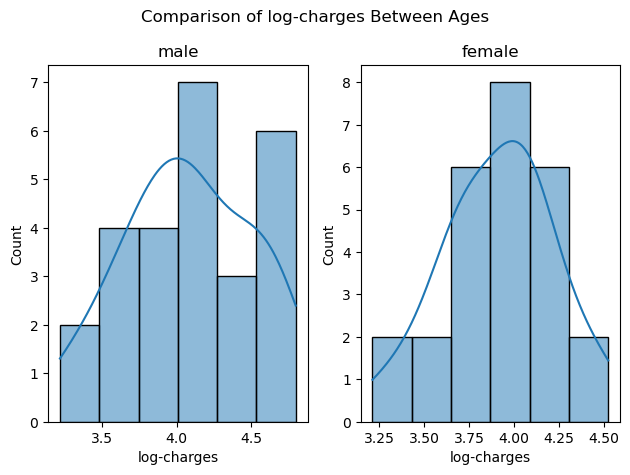

In [30]:
plt.subplot(1,2,1)
sns.histplot(male_samples, x="log-charges", kde=True)
plt.title("male")

plt.subplot(1,2,2)
sns.histplot(female_samples, x="log-charges", kde=True)
plt.title("female")

plt.suptitle("Comparison of log-charges Between Ages")
plt.tight_layout()

### Visualize QQ-Plot of Each Group

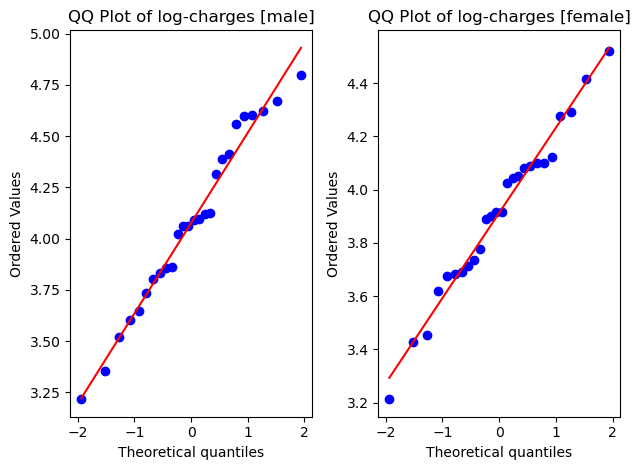

In [7]:
plt.subplot(1,2,1)
probplot(male_samples["log-charges"], plot=plt);
plt.title("QQ Plot of log-charges [male]")

plt.subplot(1,2,2)
probplot(female_samples["log-charges"], plot=plt);
plt.title("QQ Plot of log-charges [female]")
plt.tight_layout()

### Test for Normality

To ascertain the normality of our data distribution, we will employ the `scipy.stats.normaltest`. This function implements the D’Agostino and Pearson’s test, which synthesizes skewness and kurtosis into an omnibus test of normality.

- **Null Hypothesis** ($H_0$): The sample is derived from a normal distribution.
- **Alternate Hypothesis** ($H_1$): The sample is not derived from a normal distribution.


#### Male Samples

In [17]:
stat, pval = normaltest(male_samples["log-charges"])
print("statistic:", stat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

statistic: 0.9245606988258835
p-value: 0.6298457383050087
null hypothesis: ACCEPT


Given that the p-value exceeds the alpha threshold of $0.05/2$, we lack adequate evidence to refute the null hypothesis, which posits that the male sample is drawn from a normal distribution. Consequently, it is statistically reasonable to infer that the male sample adheres to a normal distribution.

#### Female Samples

In [15]:
stat, pval = normaltest(female_samples["log-charges"])
print("statistic:", stat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

statistic: 0.24589984971369896
p-value: 0.8843079432989793
null hypothesis: ACCEPT


Given that the p-value exceeds the alpha threshold of $0.05/2$, we lack adequate evidence to refute the null hypothesis, which posits that the male sample is drawn from a normal distribution. Consequently, it is statistically reasonable to infer that the female sample adheres to a normal distribution.

#### Normality Test Results

The normality tests conducted on the male and female samples yield results that allow us to presume a normal distribution for both. This foundational assumption paves the way for employing a parametric test, such as the t-test, to compare the log-charges across genders.

### Comparison of Independent Groups
Since we are comparing two independent groups, we will use the `scipy.stats.ttest_rel` function to conduct an independent samples t-test.

- Null hypothesis ($H_0$): The male and female samples have equal mean log-charges.
- Null hypothesis ($H_1$): The male and female samples have un-equal mean log-charges.

In [41]:
tstat, pval = ttest_rel(male_samples["log-charges"], female_samples["log-charges"])
print("t-statistic:", tstat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

t-statistic: 1.8624900530159152
p-value: 0.07432694759565131
null hypothesis: ACCEPT


Since the p-value is less than 0.05, we don't have sufficient statistical evidence to reject the null hypothesis that the male and female samples have equal mean log-charges. In other words, there were no significant difference between the premium charges between the male and female insured.

## Smoking and Charges

### Sample from the Dataset

In [18]:
non_smoker_samples = df0[df0["smoker"] == "no"].sample(sample_size)
smoker_samples     = df0[df0["smoker"] == "yes"].sample(sample_size)

### Compare the Distribution of Each Group

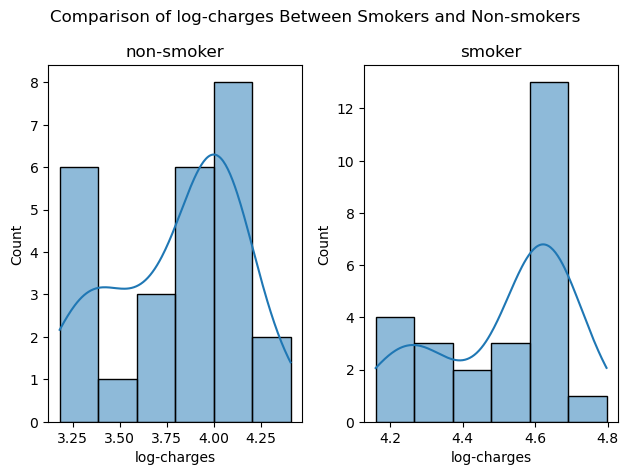

In [29]:
plt.subplot(1,2,1)
sns.histplot(non_smoker_samples, x="log-charges", kde=True)
plt.title("non-smoker")

plt.subplot(1,2,2)
sns.histplot(smoker_samples, x="log-charges", kde=True)
plt.title("smoker")

plt.suptitle("Comparison of log-charges Between Smokers and Non-smokers")
plt.tight_layout()

### Visualize QQ-Plot of Each Group

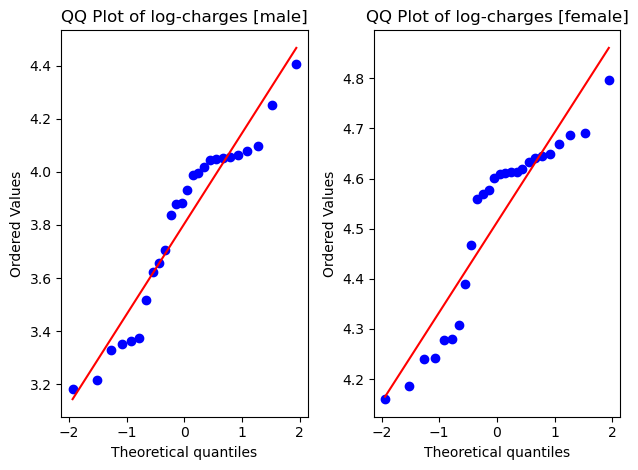

In [20]:
plt.subplot(1,2,1)
probplot(non_smoker_samples["log-charges"], plot=plt);
plt.title("QQ Plot of log-charges [male]")

plt.subplot(1,2,2)
probplot(smoker_samples["log-charges"], plot=plt);
plt.title("QQ Plot of log-charges [female]")
plt.tight_layout()

### Test for Normality
Once again, to test for normality we will use the built-in `scipy.stats.normaltest` which is based D’Agostino and Pearson’s [1], [2] test that combines skew and kurtosis to produce an omnibus test of normality.

- Null Hypothesis ($H_0$): The sample comes from a normal distribution.
- Alternate Hypothesis ($H_1$): The sample did not come from a normal distribution.

In [24]:
stat, pval = normaltest(non_smoker_samples["log-charges"])
print("statistic:", stat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

statistic: 2.4772301363183233
p-value: 0.28978527300957585
null hypothesis: ACCEPT


In [22]:
stat, pval = normaltest(smoker_samples["log-charges"])
print("statistic:", stat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

statistic: 4.136404688963576
p-value: 0.1264128242828703
null hypothesis: ACCEPT


Based on the results of normality test, we don't have sufficient evidence to reject the null hypothesis that both smoker and non-smoker's log-charges were drawn from a normal distribution. Thus, we can still assume that they were both draw from a normal distribution. Therefore, we can still use two independent samples ttest.

### Comparison of Independent Groups
Same with gender, we are still comparing two independent groups, we will still use the `scipy.stats.ttest_rel` function to conduct an independent samples t-test with the following null and alternate hypothesis:

- Null hypothesis ($H_0$): smokers and non-smoker samples have equal mean log-charges.
- Null hypothesis ($H_1$): smokers and non-smoker samples have un-equal mean log-charges.

In [25]:
tstat, pval = ttest_rel(non_smoker_samples["log-charges"], smoker_samples["log-charges"])
print("t-statistic:", tstat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

t-statistic: -8.571489477016076
p-value: 6.5287342242979695e-09
null hypothesis: REJECT


In [59]:
tstat, pval = ttest_rel(non_smoker_samples["log-charges"], smoker_samples["log-charges"], alternative="less")
print("t-statistic:", tstat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

t-statistic: -8.571489477016076
p-value: 3.2643671121489847e-09
null hypothesis: REJECT


The p-value of our ttest was less than our alpha level divided by two (since were are using two-tailed test). Therefore, we have sufficient evidence to reject the null hypothesis that smokers and non-smoker samples have equal mean log-charges. We will accept the alternate hypothesis that smokers and non-smoker samples have un-equal mean log-charges. This findings confirmed our initial observation from our exploratory data analysis.

## Region and Charges

### Sample from the Dataset

In [26]:
southeast_samples = df0[df0["region"] == "southeast"].sample(sample_size)
southwest_samples = df0[df0["region"] == "southwest"].sample(sample_size)
northeast_samples = df0[df0["region"] == "northeast"].sample(sample_size)
northwest_samples = df0[df0["region"] == "northwest"].sample(sample_size)

### Compare the Distribution of Each Group

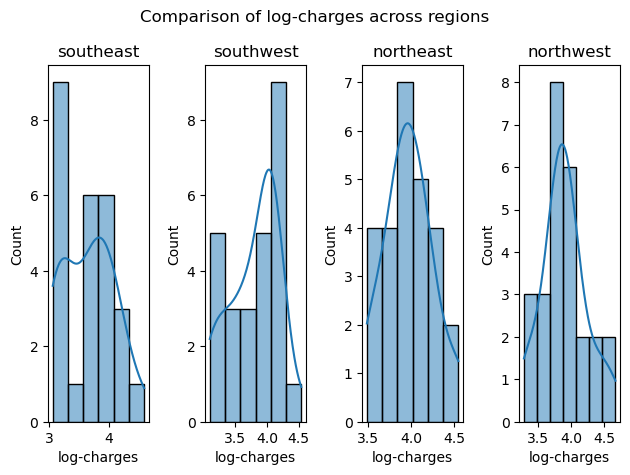

In [28]:
plt.subplot(1,4,1)
sns.histplot(southeast_samples, x="log-charges", kde=True)
plt.title("southeast")

plt.subplot(1,4,2)
sns.histplot(southwest_samples, x="log-charges", kde=True)
plt.title("southwest")

plt.subplot(1,4,3)
sns.histplot(northeast_samples, x="log-charges", kde=True)
plt.title("northeast")

plt.subplot(1,4,4)
sns.histplot(northwest_samples, x="log-charges", kde=True)
plt.title("northwest")

plt.suptitle("Comparison of log-charges across regions")
plt.tight_layout()

### Visualize QQ-Plot of Each Group

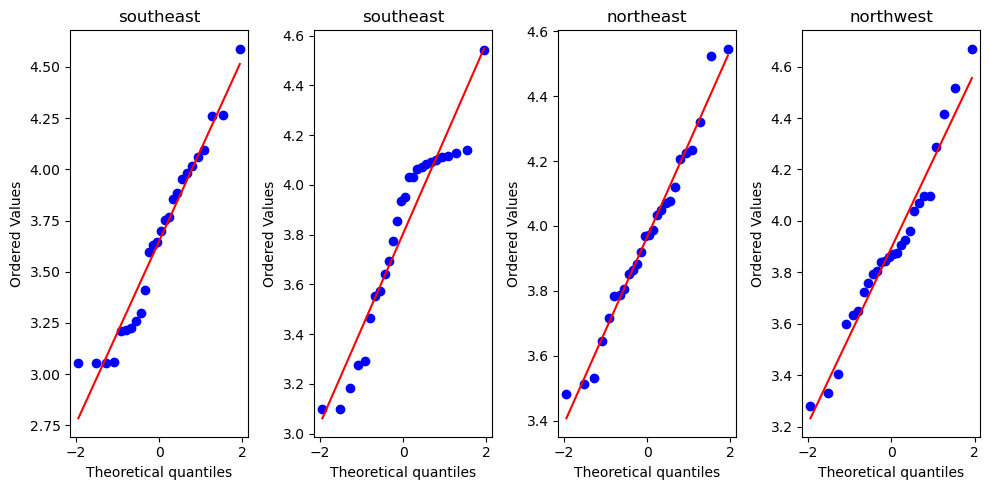

In [34]:
plt.figure().set_size_inches(10,5)
plt.subplot(1,4,1)
probplot(southeast_samples["log-charges"], plot=plt);
plt.title("southeast")

plt.subplot(1,4,2)
probplot(southwest_samples["log-charges"], plot=plt);
plt.title("southeast")
plt.tight_layout()

plt.subplot(1,4,3)
probplot(northeast_samples["log-charges"], plot=plt);
plt.title("northeast")

plt.subplot(1,4,4)
probplot(northwest_samples["log-charges"], plot=plt);
plt.title("northwest")
plt.tight_layout()

### Test for Normality
Same with the previous test, we will use the same `scipy.stats.normaltest` function with the following hypothesis:

- Null Hypothesis ($H_0$): The sample comes from a normal distribution.
- Alternate Hypothesis ($H_1$): The sample did not come from a normal distribution.

In [35]:
stat, pval = normaltest(southeast_samples["log-charges"])
print("statistic:", stat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

statistic: 1.622851530155227
p-value: 0.4442242550678992
null hypothesis: ACCEPT


In [36]:
stat, pval = normaltest(southwest_samples["log-charges"])
print("statistic:", stat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

statistic: 1.6603815742262291
p-value: 0.43596610167255445
null hypothesis: ACCEPT


In [38]:
stat, pval = normaltest(northeast_samples["log-charges"])
print("statistic:", stat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

statistic: 0.29298594610066925
p-value: 0.8637318017133327
null hypothesis: ACCEPT


In [40]:
stat, pval = normaltest(northwest_samples["log-charges"])
print("statistic:", stat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

statistic: 1.3281572763775262
p-value: 0.5147475780479962
null hypothesis: ACCEPT


The normality test of the four regions does not show enough evidence to reject our null hypothesis that they were drawn from a normal distribution. Therefore, we can assume that log-charges were normally distributed across the four regions. In addition since we are going to compare more than two independent groups, we can use an ANOVA to test our hypothesis all at once.

### Comparison of Independent Groups

To compare the mean log-charges of the four regions, we can use an ANOVA test to test the null hypothesis that the mean log-charges across all groups are equal. To calculate the f-statistic and the p-value, we can use the `scipy.stats.f_oneway` function.

- Null hypothesis ($H_0$): The mean log-charges were equal on the four regions.
- Null hypothesis ($H_1$): The mean log-charges were not equal on the four regions.

In [45]:
fstat, pval = f_oneway(
    southeast_samples["log-charges"],
    southwest_samples["log-charges"],
    northeast_samples["log-charges"],
    northwest_samples["log-charges"],
)
print("t-statistic:", tstat)
print("p-value:", pval)
print("null hypothesis:", "REJECT" if pval < alpha/2 else "ACCEPT")

t-statistic: 1.8624900530159152
p-value: 0.014617808796965899
null hypothesis: REJECT


The result of the ANOVA test above shows enough evidence to reject the null hypothesis that The mean log-charges were equal on all of the four regions. However, the test above cannot tell us which of the 4 is significantly different than the other. To examine that case further, we should conduct an adhoc test.

### ANOVA Adhoc Test
Since the ANOVA results earlier failed to reject its null hypothesis, one or more of the four region's mean log-charges is significantly different than the other. We can use Tukey's Honest Significant Difference test to perform a pairwise comparison of mean log-charges between each group. We can do that using the `statsmodels.stats.multicomp.pairwise_tukeyhsd` function.

In [56]:
# Combine the samples on each region into one dataframe
regions_df = pd.concat(
    [
        southeast_samples,
        southwest_samples,
        northeast_samples,
        northwest_samples,
    ]
)

regions_df.sample(5)

,age,sex,bmi,children,smoker,region,charges,log-charges
427,18,female,29.165,0,no,northeast,7323.734819,3.864733
1213,52,female,33.300,2,no,southwest,10806.839000,4.033699
550,63,male,30.800,0,no,southwest,13390.559000,4.126799
1189,23,female,28.000,0,no,southwest,13126.677450,4.118155
672,36,male,29.700,0,no,southeast,4399.731000,3.643426


In [53]:
tukeyhsd_table = pairwise_tukeyhsd(
    endog=regions_df["log-charges"],
    groups=regions_df["region"],
    alpha=0.05
)

print(tukeyhsd_table)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
northeast northwest  -0.0723 0.8897 -0.3353  0.1907  False
northeast southeast  -0.3168 0.0115 -0.5798 -0.0538   True
northeast southwest  -0.1619 0.3787 -0.4249  0.1011  False
northwest southeast  -0.2445 0.0781 -0.5075  0.0184  False
northwest southwest  -0.0896   0.81 -0.3526  0.1734  False
southeast southwest    0.155  0.418  -0.108   0.418  False
----------------------------------------------------------


Based on the results of the Tukey's HSD test above, the mean log-charges of northeast, northwest, and south west were the same since their pairwise adjusted p-value is less than the alpha level. On the other hand, the mean log-charges of the northeast and south east region significantly differs.

<Axes: xlabel='region', ylabel='log-charges'>

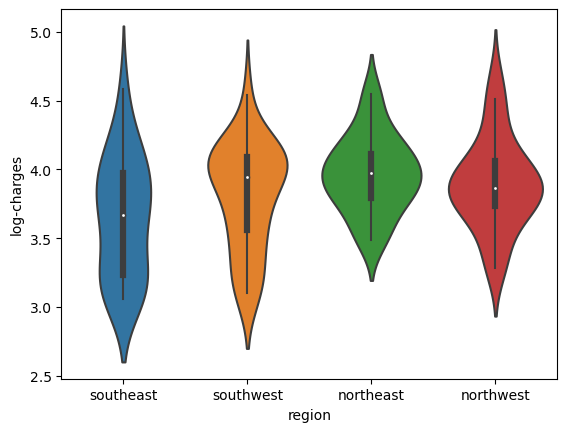

In [58]:
sns.violinplot(regions_df, x="region", y="log-charges")

## Key Findings

Through rigorous inferential statistical analysis, we have substantiated our exploratory data analysis observations. Our methodical approach commenced with a power analysis to ascertain the minimal sample size necessary for detecting a substantial effect. Utilizing an effect size of $0.8$, an alpha (type-1 error rate) of $5\%$, and a statistical power of $80\%$, we determined a requisite sample size of at least 26 to discern large effects.

Subsequently, we employed a quantile-quantile plot for a preliminary visual assessment of sample distribution, focusing on the log-transformed charges. This graphical analysis was augmented with hypothesis testing to evaluate the normality of the distribution. The outcomes affirmatively indicated that our samples originate from a normal distribution.

A t-test analysis enabled us to confirm the absence of significant disparities in the mean log-charges between male and female insured individuals. Conversely, a pronounced difference was observed between smokers and non-smokers, with smokers incurring higher charges.

Geographically, we analyzed the mean log-charge discrepancies across regions. The findings revealed no notable differences, with the exception of the northeast and southeast regions. Notably, residents of the southeast region incurred significantly lower charges compared to their northeast counterparts.

### Recommendations

This investigation was confined to the univariate impact of categorical variables on insurance premium log-charges. For a comprehensive exploration of the influence exerted by categorical and continuous variables, as well as their potential interactions on log-charges, we advocate for the implementation of regression analysis.